# RNN model for stock price forecasting

In [1]:
########Load required Modules
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import time
######import functions 
import torch.nn.functional as F
from torch.autograd import Variable
###### Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

# Preprocess dataset
use close to forecast

In [3]:
# Train
dataset_train = pd.read_csv("train.csv")
dataset_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,3429160000
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,3004460000
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,2919400000
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,2763340000
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,3038380000
...,...,...,...,...,...,...,...
2411,2016-08-01,2173.149902,2178.290039,2166.209961,2170.840088,2170.840088,3505990000
2412,2016-08-02,2169.939941,2170.199951,2147.580078,2157.030029,2157.030029,3848750000
2413,2016-08-03,2156.810059,2163.790039,2152.560059,2163.790039,2163.790039,3786530000
2414,2016-08-04,2163.510010,2168.189941,2159.070068,2164.250000,2164.250000,3709200000


In [4]:
dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])
dataset_train = dataset_train[['Close']]

In [5]:
dataset_train

,Close
0,1416.599976
1,1418.339966
2,1409.709961
3,1412.839966
4,1412.109985
...,...
2411,2170.840088
2412,2157.030029
2413,2163.790039
2414,2164.250000


In [6]:
# Val
dataset_val = pd.read_csv("val.csv")
dataset_val

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,2183.760010,2185.439941,2177.850098,2180.889893,2180.889893,3327550000
1,2016-08-09,2182.239990,2187.659912,2178.610107,2181.739990,2181.739990,3334300000
2,2016-08-10,2182.810059,2183.409912,2172.000000,2175.489990,2175.489990,3254950000
3,2016-08-11,2177.969971,2188.449951,2177.969971,2185.790039,2185.790039,3423160000
4,2016-08-12,2183.739990,2186.280029,2179.419922,2184.050049,2184.050049,3000660000
...,...,...,...,...,...,...,...
801,2019-10-14,2965.810059,2972.840088,2962.939941,2966.149902,2966.149902,2559270000
802,2019-10-15,2973.610107,3003.280029,2973.610107,2995.679932,2995.679932,3345090000
803,2019-10-16,2989.679932,2997.540039,2985.199951,2989.689941,2989.689941,3230320000
804,2019-10-17,3000.770020,3008.290039,2991.790039,2997.949951,2997.949951,3103470000


In [7]:
dataset_val['Date'] = pd.to_datetime(dataset_val['Date'])
dataset_val = dataset_val[['Close']]

In [8]:
dataset_val

,Close
0,2180.889893
1,2181.739990
2,2175.489990
3,2185.790039
4,2184.050049
...,...
801,2966.149902
802,2995.679932
803,2989.689941
804,2997.949951


In [9]:
dataset_train.shape, dataset_val.shape

((2416, 1), (806, 1))

# use Minimax strategic to rescale data

In [32]:
scaler_train = MinMaxScaler()
scaler_val = MinMaxScaler()
dataset_train_scaled = scaler_train.fit_transform(dataset_train.Close.values.reshape(-1,1))
dataset_val_scaled = scaler_val.fit_transform(dataset_val.Close.values.reshape(-1,1))


# use a window of 20 days on close price

In [11]:
window = 21

In [12]:
x_train = []
y_train = []
for index in range(len(dataset_train_scaled) - window):
    need_data = dataset_train_scaled[index: index + window]
    x_train.append(need_data[:-1])
    y_train.append(need_data[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

In [13]:
x_val = []
y_val = []
for index in range(len(dataset_val_scaled) - window):
    need_data = dataset_val_scaled[index: index + window]
    x_val.append(need_data[:-1])
    y_val.append(need_data[-1])
x_val = np.array(x_val)
y_val = np.array(y_val)

In [14]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((2395, 20, 1), (2395, 1), (785, 20, 1), (785, 1))

In [15]:
x_train_torch = torch.from_numpy(x_train).type(torch.Tensor)
y_train_torch = torch.from_numpy(y_train).type(torch.Tensor)

x_val_torch = torch.from_numpy(x_val).type(torch.Tensor)
y_val_torch = torch.from_numpy(y_val).type(torch.Tensor)

In [16]:
##### DEFINE RNN net as described above: 
class StackedRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(StackedRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Create a list to hold multiple RNN layers
        self.rnn_layers = nn.ModuleList([nn.RNN(input_dim if i == 0 else hidden_dim,
                                                hidden_dim,
                                                batch_first=True)
                                         for i in range(num_layers)])
        
        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden states
        hiddens = [torch.zeros(1, x.size(0), self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        
        # Forward pass through each RNN layer
        for i, rnn_layer in enumerate(self.rnn_layers):
            out, hiddens[i] = rnn_layer(x if i == 0 else out, hiddens[i])
        
        out = self.fc(out[:, -1, :])
        return out

In [17]:
# Set hyperparameter
num_epochs = 200# number of iterations
input_dim = 1 # dimension of input data
hidden_dim = 64 # dimension of hidden layers
num_layers = 3 # number of RNN
output_dim = 1# dimension of output data

# Set the Loss & Optimizer

In [18]:
####### Declare a net
stacked_rnn_model = StackedRNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

#######define LOSS and Optimizer
criterion = torch.nn.MSELoss(reduction='mean')
#define the Mean Squared Error (MSE) loss function for regression tasks
# optimizer = optim.SGD(model.parameters(), lr = 0.01)
optimiser = torch.optim.Adam(stacked_rnn_model.parameters(), lr=0.005)
####### show the net frame
stacked_rnn_model

StackedRNN(
  (rnn_layers): ModuleList(
    (0): RNN(1, 64, batch_first=True)
    (1-2): 2 x RNN(64, 64, batch_first=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

# train the model

In [19]:
# Ensure the stacked_rnn_model is in training mode
stacked_rnn_model.train()
hist = []  # Using a list instead of np.zeros for dynamic storage of losses
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = stacked_rnn_model(x_train_torch.to(device))
    loss = criterion(y_train_pred, y_train_torch.to(device))
    if t % 10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist.append(loss.item())
    # Zero the parameter gradients
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

torch.save(stacked_rnn_model.state_dict(), 'stacked_rnn_model.pth')  # Save the model state_dict
training_time = time.time() - start_time
print("Training time: {}".format(training_time))
print('Finished Training')


Epoch  0 MSE:  0.39723432064056396
Epoch  10 MSE:  0.009627292864024639
Epoch  20 MSE:  0.015525929629802704
Epoch  30 MSE:  0.0042466954328119755
Epoch  40 MSE:  0.0028321866411715746
Epoch  50 MSE:  0.0008995297248475254
Epoch  60 MSE:  0.0002851290046237409
Epoch  70 MSE:  0.00031141185900196433
Epoch  80 MSE:  0.00023807678371667862
Epoch  90 MSE:  0.00023524987045675516
Epoch  100 MSE:  0.00021721457596868277
Epoch  110 MSE:  0.00020808661065530032
Epoch  120 MSE:  0.0002022856060648337
Epoch  130 MSE:  0.00019701718701981008
Epoch  140 MSE:  0.00019263314607087523
Epoch  150 MSE:  0.00018876079411711544
Epoch  160 MSE:  0.00018517978605814278
Epoch  170 MSE:  0.00018187021487392485
Epoch  180 MSE:  0.00017877272330224514
Epoch  190 MSE:  0.00017585977911949158
Training time: 23.545005798339844
Finished Training


# Evalue the model

In [20]:
########Load pretrain model
# Create an instance of the StackedRNN model
final_model = StackedRNN(input_dim, hidden_dim, output_dim, num_layers)

# Load the model's state dictionary
final_model.load_state_dict(torch.load('stacked_rnn_model.pth'))

# Move the model to the specified device
final_model = final_model.to(device)


In [21]:
########Evaluate model
final_model.eval()
y_train_model = scaler_train.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train_original = scaler_train.inverse_transform(y_train)


y_val_pred = final_model(x_val_torch.to(device))
y_val_model = scaler_val.inverse_transform(y_val_pred.detach().cpu().numpy())
y_val_original = scaler_val.inverse_transform(y_val)

In [22]:
y_val_model.shape, y_val_original.shape

((785, 1), (785, 1))

# Visualization

<Figure size 2560x1920 with 0 Axes>

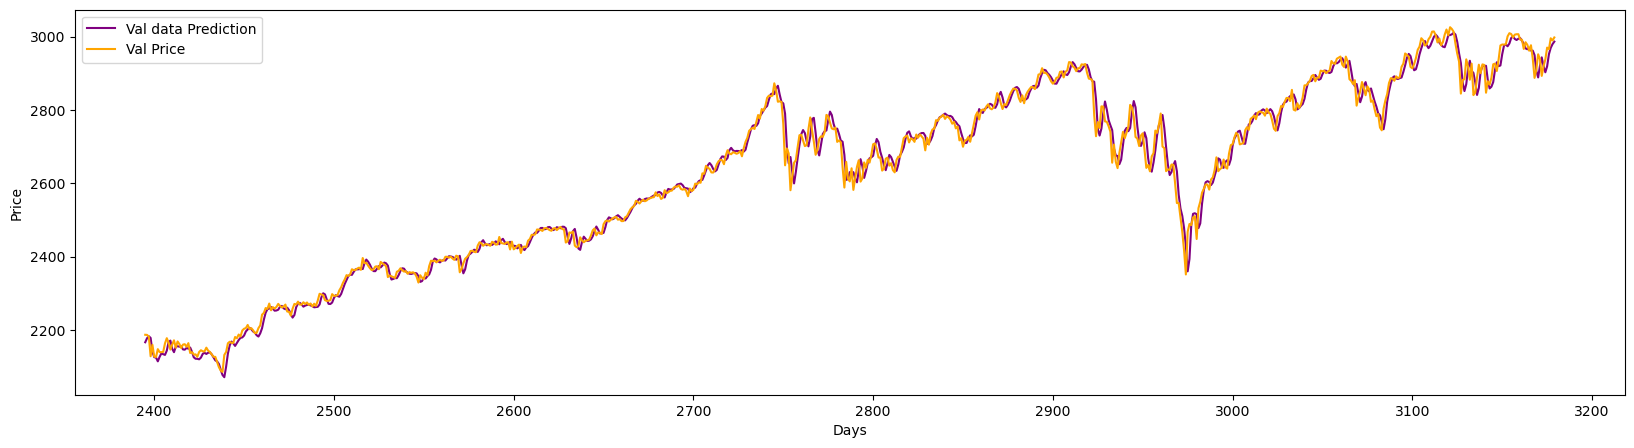

In [23]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 5))
#plt.plot(y_train_original, color = 'blue', label = 'Price')
#plt.plot(y_train_model, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(index_val, y_val_model, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()
plt.savefig("RNN-Val-Result1.png", dpi=500)
plt.show()
df_Stacked_RNN_result = pd.DataFrame({'Original':y_val_original.flatten(),'Val Prediction':y_val_model.flatten()})
df_Stacked_RNN_result.to_csv(r"RNN-Val-Result.csv",sep=',')

<Figure size 2560x1920 with 0 Axes>

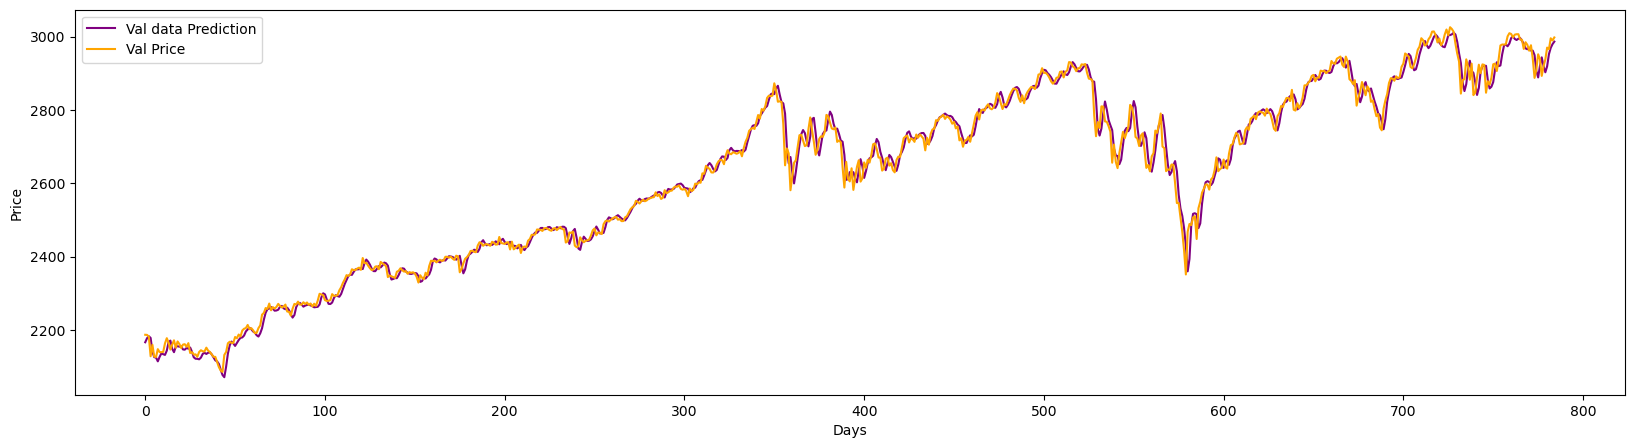

In [24]:
N_val = len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1)  #+ N_original

## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 5))
#plt.plot(y_train_original, color = 'blue', label = 'Price')
#plt.plot(y_train_model, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(index_val, y_val_model, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()
plt.savefig("RNN-Val-Result1.png", dpi=500)
plt.show()
# df_Stacked_RNN_result = pd.DataFrame({'Original':y_val_original.flatten(),'Val Prediction':y_val_model.flatten()})
# df_Stacked_RNN_result.to_csv(r"RNN-Val-Result.csv",sep=',')

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate the mean squared_error
mse = mean_squared_error(y_val_original, y_val_model)

# calculate the r2 score
r2 = r2_score(y_val_original, y_val_model)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate Determination Coefficient (DS)
def calculate_ds(y_true, y_pred):
    d = []
    for i in range(1,len(y_true)):
        if (y_true[i]-y_pred[i-1])*(y_pred[i] - y_true[i-1])>=0:
            d.append(1)
        else:
            d.append(0)
    DS = (1/(len(y_true)-1))*np.sum(d)*100  
    return DS

# Calculate MAPE
mape = calculate_mape(y_val_original, y_val_model)

# Calculate DS
DS = calculate_ds(y_val_original, y_val_model)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Directional symmetry (DS):", DS)

Mean Squared Error (MSE): 583.854184028753
R-squared (R²): 0.9903647830795296
Mean Absolute Percentage Error (MAPE): 0.6245872237953842
Directional symmetry (DS): 32.6530612244898


# Backtest

In [26]:
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    cash = initial_cash
    shares = 0
    total_assets = initial_cash
    # make sure each time only do one strategy （state machine）
    position = 0  # 0 for no position, 1 for long, -1 for short

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
        actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

        if position == 0:  # No position
            # long buy
            if predicted_change > threshold and cash >= original_prices[i]:
                shares_bought = cash // original_prices[i]
                shares += shares_bought
                cash -= shares_bought * original_prices[i]
                position = 1  # Long position opened
            # short buy
            elif predicted_change < -threshold and cash >= original_prices[i]:
                shares_sold_short = cash // original_prices[i]
                shares += shares_sold_short
                cash -= shares_sold_short * original_prices[i]
                position = -1  # Short position opened

        elif position == 1:  # Long position
            # long sell
            if predicted_change < -threshold:
                cash += shares * original_prices[i]
                shares = 0
                position = 0  # Exit long position
            # short sell
        elif position == -1:  # Short position
            if predicted_change > threshold:
                cash += shares * original_prices[i]
                shares = 0
                position = 0  # Exit short position

        total_assets = cash + shares * original_prices[i]

    return total_assets


In [27]:
initial_cash = 500000
threshold = 0.0007
# Applying the backtest function to the RNN model's predictions
final_assets = backtest(y_val_model[:, 0], y_val_original[:, 0], threshold=threshold, initial_cash=initial_cash)
total_return = final_assets - initial_cash
return_rate = (total_return / initial_cash) * 100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:", return_rate)


Final Assets: 617952.865234375 Total Return: 117952.865234375 Return Rate: 23.590573046875


In [30]:
initial_cash = 500000
best_threshold = 0
best_return_rate = 0

# seeking best threshold between 0.0001 to 0.009
for threshold in range(1, 100):
    threshold /= 10000  # 将范围调整为0.0001到0.0099
    # get the "final_assets" from backtest function 
    final_assets = backtest(y_val_model[:, 0], y_val_original[:, 0], threshold=threshold, initial_cash=initial_cash)
    total_return = final_assets - initial_cash
    return_rate = (total_return / initial_cash) * 100
    # sorting return rate find the best one
    if return_rate > best_return_rate:
        best_return_rate = return_rate
        best_threshold = threshold

#print("Best Threshold:", best_threshold, "Best Return Rate:", best_return_rate)
print("Best Threshold:", best_threshold, "Final Assets:", final_assets, "Total Return:", total_return,"Best Return Rate:", best_return_rate,)

Best Threshold: 0.0041 Final Assets: 661161.3198242188 Total Return: 161161.31982421875 Best Return Rate: 46.960853125
